## Objective of the study

Use decision tree modeling on the pre-processed diabetes dataset to be able to classify and predict whether a person has diabetes, borderline diabetes or no diabetes.

### Import required libraries

In [140]:
import pandas as pd

### Read the pre-processed dataset

In [141]:
df = pd.read_csv("../data/processed/nhanes_data_processed.csv")

In [142]:
# Show the first 5 rows in the dataset

df.head()

,bmi,high_blood_pressure,gender,age,diabetes,lifetime_100_cigs_smoked,current_smoking_freq,hba1c_percentage_log,fpg_mmol_L_log,hdl_mmol_L_log,bmi_age_interaction,glucose_hba1c_interaction,bp_age_interaction
0,27.0,1,1,43,2,1,3,1.722767,1.835776,0.148420,11.610,3.162614,43
1,33.5,1,1,66,2,1,3,1.722767,1.704748,0.438255,22.110,2.936883,66
2,30.2,0,1,34,2,1,3,1.629241,1.713798,0.173953,10.268,2.792189,0
3,27.3,0,0,56,2,1,3,1.609438,1.752672,0.565314,15.288,2.820817,0
4,21.4,1,1,80,2,1,3,1.526056,1.597365,0.751416,17.120,2.437669,80


### Split the dataset into training, cross validation and test sets

The dataset will be split into two parts:
- 80% training set - to train the model
- 20% test set - to give a fair estimate of the chosen model's performance against new examples

Due to the imbalance of classes, StratifiedKFold will be used to split the training set into 5 stratified parts to do cross validation during the training process.

In [143]:
# Split the predictor features and target feature

X = df.drop("diabetes", axis=1)
y = df["diabetes"]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1134, 12)
y shape: (1134,)


In [144]:
# Create a stratified train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}\n")
print(f"Training set class distribution: {y_train.value_counts()}\n")
print(f"Test set class distribution: {y_test.value_counts()}")

Training set shape: (907, 12)
Test set shape: (227, 12)

Training set class distribution: diabetes
2    742
1    124
3     41
Name: count, dtype: int64

Test set class distribution: diabetes
2    186
1     31
3     10
Name: count, dtype: int64


In [145]:
# Initialise StratifiedKFold for evaluation

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Testing different hyperparameters

To optimise the decision tree, different values of hyperparameters will be tested to find the value of hyperparameter that produces a reasonably good recall score and F1 score.

Recall is used as the primary evaluation metric as the cost of missing a diabetes case (false negative) outweighs the inconvenience arising from additional screening tests due to false positive diagnoses.

F1 score is used as the secondary metric to ensure that improvements in recall does not result in a significantly high number of false positive diagnoses.

In [146]:
# Create a list of values for the Decision Tree Classifier hyperparameters to observe their effects on model performance

max_depth_list = [1, 2, 3, 4, 5, 10, 20]
min_samples_split_list = [2, 5, 10, 25, 50, 100, 200, 300, 500]
min_samples_leaf_list = [1, 2, 5, 10, 15, 20, 25, 50, 100, 250, 500]
CRITERION = "entropy"
CLASS_WEIGHT = "balanced"
RANDOM_STATE = 42

In [147]:
# Import required libraries for evaluation

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

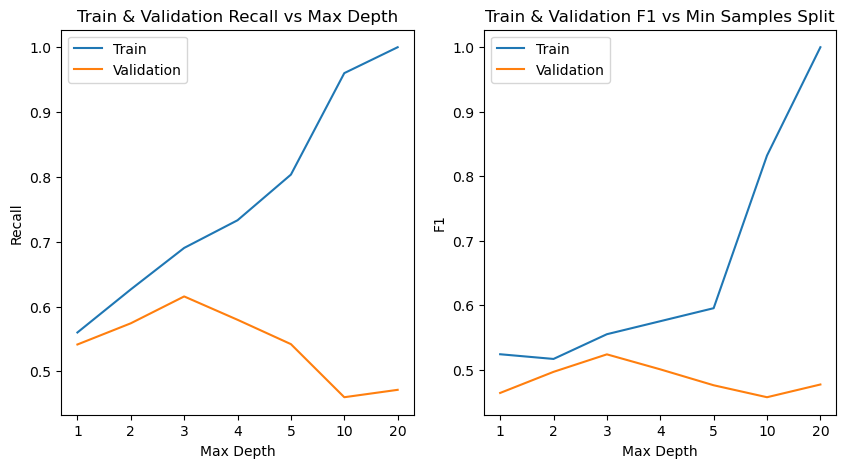

In [148]:
# Evaluating max_depth

recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for max_depth in max_depth_list:
    dt = DecisionTreeClassifier(criterion=CRITERION,
                                max_depth=max_depth,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE)
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train & Validation Recall vs Max Depth")
plt.xlabel("Max Depth")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train & Validation F1 vs Min Samples Split")
plt.xlabel("Max Depth")
plt.ylabel("F1")
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

Based on the above plots, both recall and F1 scores are increasing in training and validation when max_depth approaches 3, before it decreases as max_depth decreasese.

Hence, max_depth=3 is optimal to use for the optimised model.

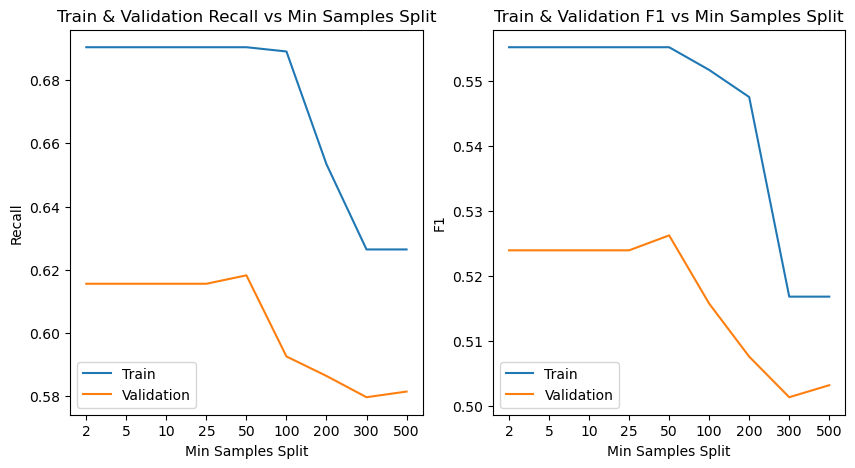

In [149]:
# Evaluating min_samples_split

recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_split in min_samples_split_list:
    dt = DecisionTreeClassifier(criterion=CRITERION,
                                min_samples_split=min_samples_split,
                                max_depth=3,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE)
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train & Validation Recall vs Min Samples Split")
plt.xlabel("Min Samples Split")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train & Validation F1 vs Min Samples Split")
plt.xlabel("Min Samples Split")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

Based on the above plots, recall and F1 scores remain relatively constant when min_samples_split are between the values of 2 and 25. Both recall and F1 score increases slightly in the validation when min_samples_split=50.

To keep the model simple, min_samples_split=2 will be optimal. However, min_samples_split=10 will be tested later on the optimised model to identify if it makes any improvement to the optimised model's prediction.

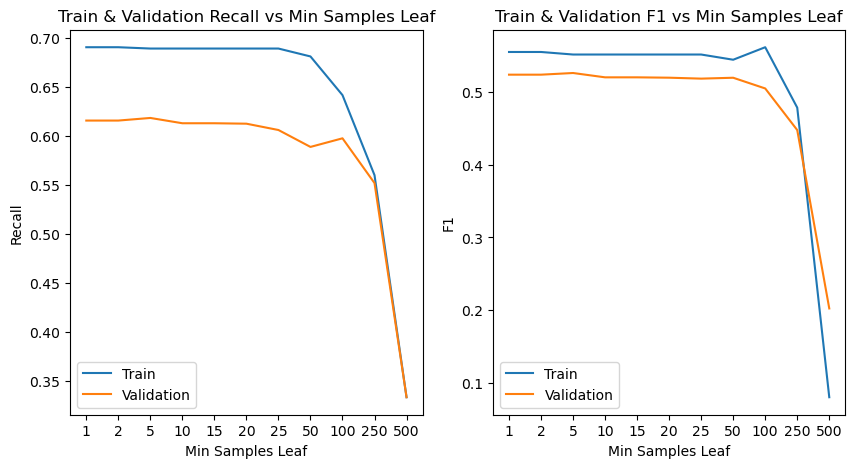

In [150]:
# Evaluating min_samples_leaf

recall_scores_train = []
recall_scores_cv = []
f1_scores_train =[]
f1_scores_cv = []

for min_samples_leaf in min_samples_leaf_list:
    dt = DecisionTreeClassifier(criterion=CRITERION,
                                min_samples_leaf=min_samples_leaf,
                                max_depth=3,
                                min_samples_split=2,
                                class_weight=CLASS_WEIGHT,
                                random_state=RANDOM_STATE)
    
    dt.fit(X_train, y_train)
    pred_train = dt.predict(X_train)
    
    recall_train = recall_score(y_train, pred_train, average="macro")
    f1_train = f1_score(y_train, pred_train, average="macro")
    
    recall_scores_train.append(recall_train)
    f1_scores_train.append(f1_train)
    
    recall_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="recall_macro")
    f1_cv = cross_val_score(dt, X_train, y_train, cv=cv, scoring="f1_macro")
    
    recall_cv_mean = recall_cv.mean()
    f1_cv_mean = f1_cv.mean()
    
    recall_scores_cv.append(recall_cv_mean)
    f1_scores_cv.append(f1_cv_mean)
    
    
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.title("Train & Validation Recall vs Min Samples Leaf")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Recall")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(recall_scores_train)
plt.plot(recall_scores_cv)
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.title("Train & Validation F1 vs Min Samples Leaf")
plt.xlabel("Min Samples Leaf")
plt.ylabel("F1")
plt.xticks(ticks=range(len(min_samples_leaf_list)), labels=min_samples_leaf_list)
plt.plot(f1_scores_train)
plt.plot(f1_scores_cv)
plt.legend(["Train", "Validation"])

plt.show()

Based on the above plots, both recall and F1 scores peak at min_samples_leaf=5 in validation, while the recall and F1 scores in training decreases slightly, reducing the difference between the training and validation scores, and hence less overfitting.

min_samples_leaf=5 is the optimal value to use for the optimised model.

In summary, the best hyperparameters to use for the optimised model are:
- max_depth : 3
- min_samples_split : 2
- min_samples_leaf : 5

Upon further analysis using the code below, min_samples_split of 50 resulted in the same results as min samples split of 2. Hence, min_samples_split of 2 is chosen to keep the optimised model simple.

In [151]:
# Build the optimised decision tree model

dt_model = DecisionTreeClassifier(criterion=CRITERION,
                                            max_depth=3,
                                            min_samples_split=2,
                                            min_samples_leaf=5,
                                            class_weight=CLASS_WEIGHT,
                                            random_state=RANDOM_STATE)

# dt_model learn from the training set and predict on the test set

dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

y_pred

array([2, 3, 3, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 3, 1, 2, 3, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 3, 2, 2, 2, 3,
       3, 2, 2, 3, 2, 1, 2, 1, 2, 2, 3, 3, 2, 1, 2, 2, 2, 2, 3, 1, 2, 2,
       2, 2, 2, 3, 1, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 1, 2, 2, 2,
       3, 2, 3, 2, 3, 2, 2, 3, 1, 2, 3, 2, 2, 1, 3, 2, 3, 3, 1, 3, 2, 3,
       2, 2, 2, 2, 1, 1, 3, 2, 2, 3, 3, 3, 2, 3, 1, 1, 3, 3, 1, 2, 2, 1,
       3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 3, 2, 3, 3, 2, 3, 2, 1, 2, 3, 3, 2, 2, 2, 1, 2, 1, 1, 3, 2,
       3, 2, 3, 1, 2, 3, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 1, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 3, 1, 1, 1, 1, 3, 2, 2, 1, 2,
       2, 3, 2, 2, 1, 2, 2], dtype=int64)

### Visualise the decision tree

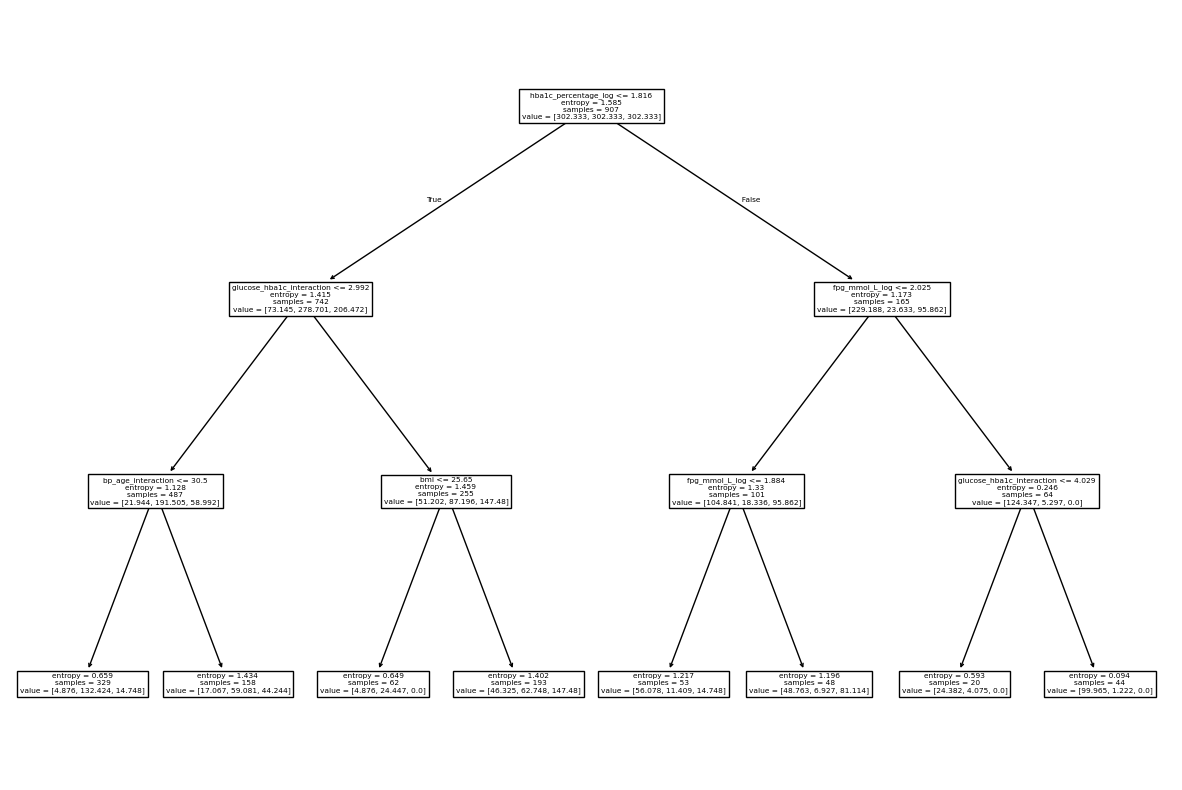

In [152]:
# Import library to show the optimised decision tree model as a plot

from sklearn.tree import plot_tree

feature_cols = X.columns

plt.figure(figsize=(15,10))
plot_tree(dt_model.fit(X_train, y_train), feature_names=feature_cols)
plt.show()

In [153]:
# Show all class names

dt_model.classes_

array([1, 2, 3], dtype=int64)

### Confusion Matrix and Classfication Report

Evaluation of the optimised decision tree model will be done using a confusion matrix and classfication report.

In [154]:
# Import library to show confusion matrix

from sklearn.metrics import confusion_matrix

# Generate confusion matrix and display with each row and column labelled

cnf_matrix_test = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)

cnf_matrix_test_df = pd.DataFrame(cnf_matrix_test, columns=["Diabetes_yes_pred", "Diabetes_no_pred", "Diabetes_borderline_pred"], 
                                    index=["Diabetes_yes_actual", "Diabetes_no_actual", "Diabetes_borderline_actual"])

cnf_matrix_test_df

,Diabetes_yes_pred,Diabetes_no_pred,Diabetes_borderline_pred
Diabetes_yes_actual,20,4,7
Diabetes_no_actual,12,128,46
Diabetes_borderline_actual,3,2,5


In [155]:
# Import library to generate classification report

from sklearn.metrics import classification_report

# Show classification report

print("Classification report of optimised decision tree")
print(classification_report(y_test, y_pred, target_names=["Diabetes_yes", "Diabetes_no", "Diabetes_borderline"]))

Classification report of optimised decision tree
                     precision    recall  f1-score   support

       Diabetes_yes       0.57      0.65      0.61        31
        Diabetes_no       0.96      0.69      0.80       186
Diabetes_borderline       0.09      0.50      0.15        10

           accuracy                           0.67       227
          macro avg       0.54      0.61      0.52       227
       weighted avg       0.86      0.67      0.74       227



### Feature Importance

In detecting Type 2 diabetes, it is important to identify which features contribute to the optimised model's prediction.
This will also be used in comparison to other classification techniques explored later.

Feature importance valeus (entropy) sorted in descending order
hba1c_percentage_log: 0.4805268609890746
fpg_mmol_L_log: 0.22901232460651588
glucose_hba1c_interaction: 0.14334010978800146
bmi: 0.07768351475792865
bp_age_interaction: 0.06943718985847923
high_blood_pressure: 0.0
gender: 0.0
age: 0.0
lifetime_100_cigs_smoked: 0.0
current_smoking_freq: 0.0
hdl_mmol_L_log: 0.0
bmi_age_interaction: 0.0


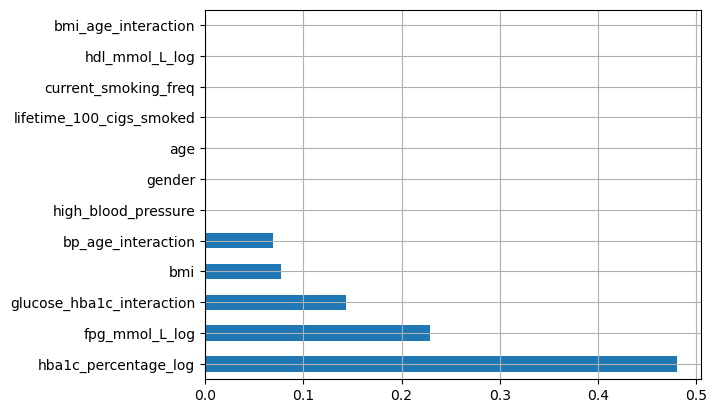

In [156]:
# Show the entropy importance of each feature

feature_importance = pd.Series(dt_model.feature_importances_, index=feature_cols)

feature_importance_sorted = feature_importance.sort_values(ascending=False)

print("Feature importance valeus (entropy) sorted in descending order")

for col, feature_val in feature_importance_sorted.items():
    print(f"{col}: {feature_val}")

feature_importance_sorted.plot(kind="barh")
plt.grid()